**I. Introduction**

Image enhancement is a method of improving the quality of an image and contrast is a major aspect. Traditional methods of contrast enhancement like histogram equalization results in over/under enhancement of the image especially a lower resolution one.

This project aims at developing a new Fuzzy Inference System to enhance the contrast of the images overcoming the shortcomings of the traditional methods.

Results obtained using both the approaches are compared.

**II. Contrast enhancement techniques**

Gray-level transformation based techniques: logarithm transformation, power-law transformation, piecewise-linear transformation, etc.

Histogram based processing techniques: histogram equalization (HE), histogram specification, etc.

The most popular method is histogram equalization, which is based on the assumption that a uniformly distributed grayscale histogram will have the best visual contrast.

Other advanced histogram based enhancement methods include bi-histogram equalization (BHE), block-overlapped histogram equalization, multi-scale adaptive histogram equalization, shape preserving local histogram modification, etc.

**III. Proposed fuzzy-based method**

**Description:**

(i) Convert input image from RGB to CIELAB, progress on L channel

(ii) Calculate the average pixel intensity - M value

(iii) Fuzzification: For each pixel, calculate degree of membership of each class based on pixel intensity and M value.  Intensity∈[0,255] 

(iv) Inference: Calculate the output fuzzy set from the input pixel intensity based on the proposed rule set

(v) Defuzzification: For each pixel, calculate centroid value of its output fuzzy set.  Centroid∈[−50,305] 

(vi) Normalize output pixel intensity from [-50, 305] to [0, 255]

(vii) Merge modified L channel to the original AB channels, convert output image from CIELAB to RGB.

**Fuzzification of Pixel Intensity**

In [1]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from glob2 import glob

In [3]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5*np.square((x-mean)/std))

# Membership Functions:
def ExtremelyDark(x, M):
    return G(x, -50, M/6)

def VeryDark(x, M):
    return G(x, 0, M/6)

def Dark(x, M):
    return G(x, M/2, M/6)

def SlightlyDark(x, M):
    return G(x, 5*M/6, M/6)

def SlightlyBright(x, M):
    return G(x, M+(255-M)/6, (255-M)/6)

def Bright(x, M):
    return G(x, M+(255-M)/2, (255-M)/6)

def VeryBright(x, M):
    return G(x, 255, (255-M)/6)

def ExtremelyBright(x, M):
    return G(x, 305, (255-M)/6)

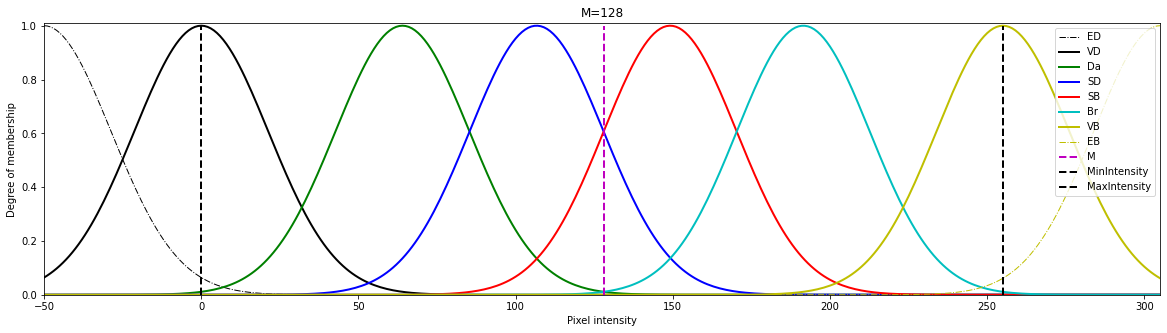

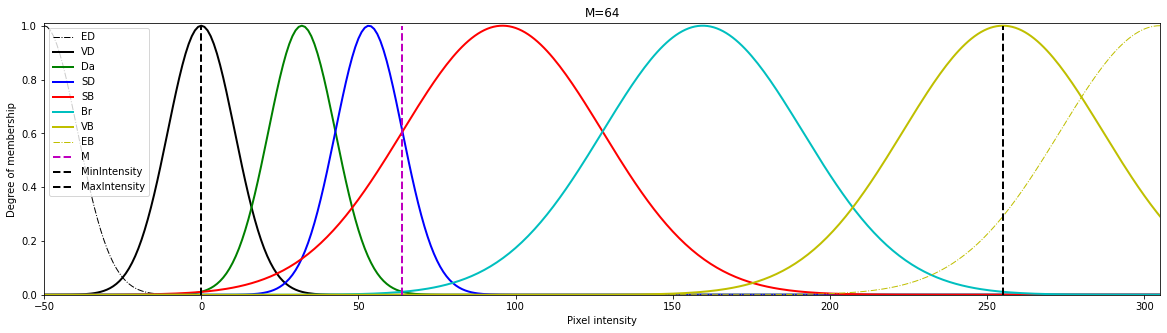

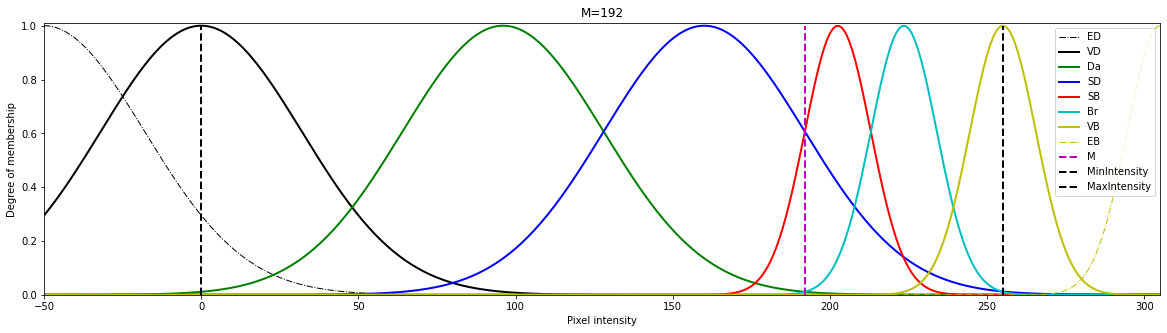

In [6]:
for M in (128, 64, 192):
    x = np.arange(-50, 306)
    
    ED = ExtremelyDark(x, M)
    VD = VeryDark(x, M)
    Da = Dark(x, M)
    SD = SlightlyDark(x, M)
    SB = SlightlyBright(x, M)
    Br = Bright(x, M)
    VB = VeryBright(x, M)
    EB = ExtremelyBright(x, M)

    plt.figure(figsize=(20,5))
    plt.plot(x, ED, 'k-.',label='ED', linewidth=1)
    plt.plot(x, VD, 'k-',label='VD', linewidth=2)
    plt.plot(x, Da, 'g-',label='Da', linewidth=2)
    plt.plot(x, SD, 'b-',label='SD', linewidth=2)
    plt.plot(x, SB, 'r-',label='SB', linewidth=2)
    plt.plot(x, Br, 'c-',label='Br', linewidth=2)
    plt.plot(x, VB, 'y-',label='VB', linewidth=2)
    plt.plot(x, EB, 'y-.',label='EB', linewidth=1)
    plt.plot((M, M), (0, 1), 'm--', label='M', linewidth=2)
    plt.plot((0, 0), (0, 1), 'k--', label='MinIntensity', linewidth=2)
    plt.plot((255, 255), (0, 1), 'k--', label='MaxIntensity', linewidth=2)
    plt.legend()
    plt.xlim(-50, 305)
    plt.ylim(0.0, 1.01)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Degree of membership')
    plt.title(f'M={M}')
    plt.show()

**3. Rule Set**

i. IF input is Very Dark THEN output is Extremely Dark.

ii. IF input is Dark THEN output is Very Dark.

iii. IF input is Slightly Dark THEN output is Dark.

iv. IF input is Slightly Bright THEN output is Bright.

v. IF input is Bright THEN output is Very Bright.

vi. IF input is Very Bright THEN output is Extremely Bright.

**4. Inference and Defuzzication (Mamdani's method)**

In [8]:
def OutputFuzzySet(x, f, M, thres):
    x = np.array(x)
    result = f(x, M)
    result[result > thres] = thres
    return result

def AggregateFuzzySets(fuzzy_sets):
    return np.max(np.stack(fuzzy_sets), axis=0)

def Infer(i, M, get_fuzzy_set=False):
    # Calculate degree of membership for each class
    VD = VeryDark(i, M)
    Da = Dark(i, M)
    SD = SlightlyDark(i, M)
    SB = SlightlyBright(i, M)
    Br = Bright(i, M)
    VB = VeryBright(i, M)
    # Fuzzy Inference:
    x = np.arange(-50, 306)
    Inferences = (
        OutputFuzzySet(x, ExtremelyDark, M, VD),
        OutputFuzzySet(x, VeryDark, M, Da),
        OutputFuzzySet(x, Dark, M, SD),
        OutputFuzzySet(x, Bright, M, SB),
        OutputFuzzySet(x, VeryBright, M, Br),
        OutputFuzzySet(x, ExtremelyBright, M, VB)
    )
    
    # Calculate AggregatedFuzzySet:
    fuzzy_output = AggregateFuzzySets(Inferences)
    # Calculate crisp value of centroid
    if get_fuzzy_set:
        return np.average(x, weights=fuzzy_output), fuzzy_output
    return np.average(x, weights=fuzzy_output)

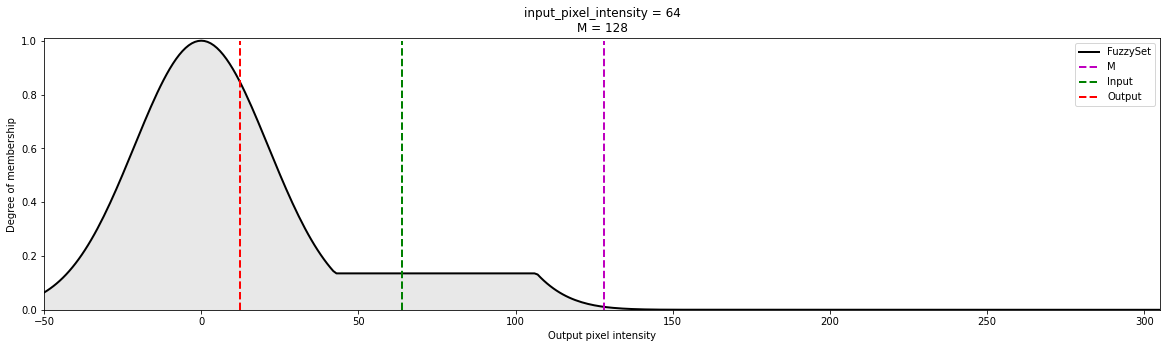

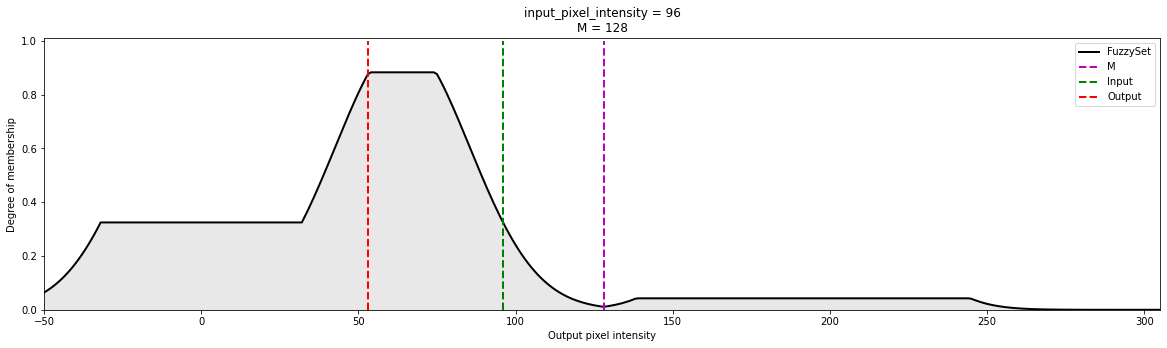

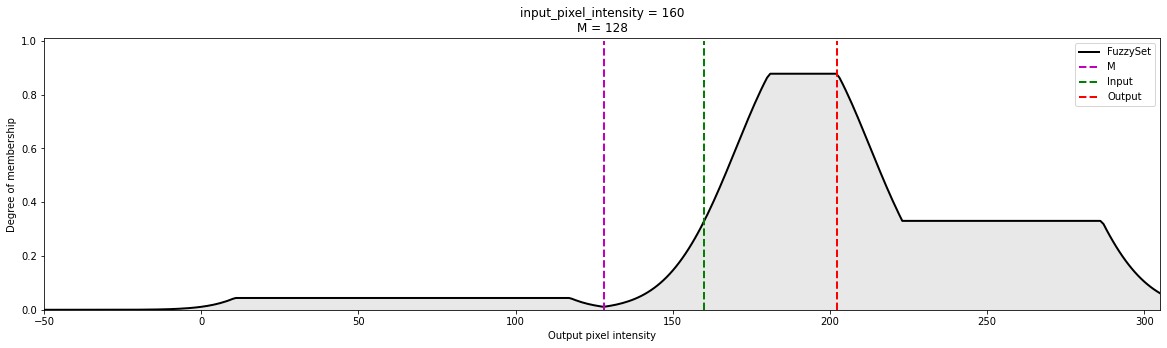

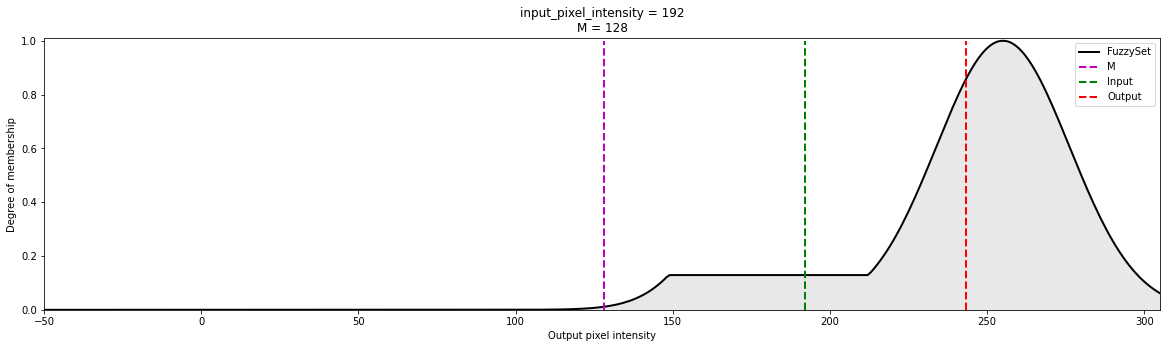

In [9]:
for pixel in (64, 96, 160, 192):
    M = 128
    x = np.arange(-50, 306)
    centroid, output_fuzzy_set = Infer(np.array([pixel]), M, get_fuzzy_set=True)
    plt.figure(figsize=(20,5))
    plt.plot(x, output_fuzzy_set, 'k-',label='FuzzySet', linewidth=2)
    plt.plot((M, M), (0, 1), 'm--', label='M', linewidth=2)
    plt.plot((pixel, pixel), (0, 1), 'g--', label='Input', linewidth=2)
    plt.plot((centroid, centroid), (0, 1), 'r--', label='Output', linewidth=2)
    plt.fill_between(x, np.zeros(356), output_fuzzy_set, color=(.9, .9, .9, .9))
    plt.legend()
    plt.xlim(-50, 305)
    plt.ylim(0.0, 1.01)
    plt.xlabel('Output pixel intensity')
    plt.ylabel('Degree of membership')
    plt.title(f'input_pixel_intensity = {pixel}\nM = {M}')
    plt.show()

CPU times: user 47.4 ms, sys: 791 µs, total: 48.1 ms
Wall time: 48.2 ms
CPU times: user 48.7 ms, sys: 0 ns, total: 48.7 ms
Wall time: 49 ms
CPU times: user 46.7 ms, sys: 483 µs, total: 47.2 ms
Wall time: 47.4 ms
CPU times: user 47.7 ms, sys: 0 ns, total: 47.7 ms
Wall time: 47.7 ms
CPU times: user 58.2 ms, sys: 4.45 ms, total: 62.6 ms
Wall time: 60 ms


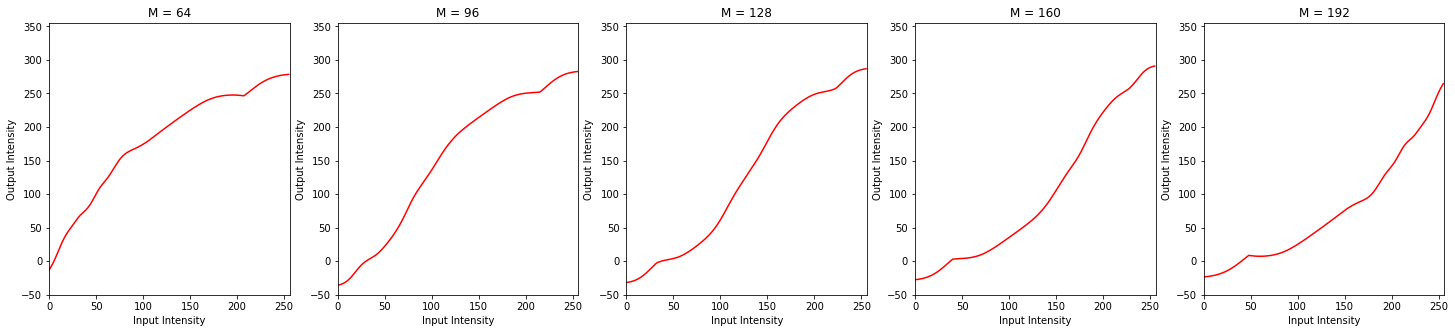

In [10]:
means = (64, 96, 128, 160, 192)
plt.figure(figsize=(25,5))
for i in range(len(means)):
    M = means[i]
    x = np.arange(256)
    %time y = np.array([Infer(np.array([i]), M) for i in x])
    plt.subplot(1, len(means), i+1)
    plt.plot(x, y, 'r-', label='IO mapping')
    plt.xlim(0, 256)
    plt.ylim(-50, 355)
    plt.xlabel('Input Intensity')
    plt.ylabel('Output Intensity')
    plt.title(f'M = {M}')
plt.show()

**IV. Demonstration**

In [11]:
# Proposed fuzzy method
def FuzzyContrastEnhance(rgb):
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    
    # Get L channel
    l = lab[:, :, 0]
    
    # Calculate M value
    M = np.mean(l)
    if M < 128:
        M = 127 - (127 - M)/2
    else:
        M = 128 + M/2
        
        # Precompute the fuzzy transform
    x = list(range(-50,306))
    FuzzyTransform = dict(zip(x,[Infer(np.array([i]), M) for i in x]))
    
    # Apply the transform to l channel
    u, inv = np.unique(l, return_inverse = True)
    l = np.array([FuzzyTransform[i] for i in u])[inv].reshape(l.shape)
    
    # Min-max scale the output L channel to fit (0, 255):
    Min = np.min(l)
    Max = np.max(l)
    lab[:, :, 0] = (l - Min)/(Max - Min) * 255
    
    # Convert LAB to RGB
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Traditional method of histogram equalization
def HE(rgb):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = cv2.equalizeHist(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Contrast Limited Adaptive Histogram Equalization
def CLAHE(rgb):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [12]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample.jpg


In [13]:
data = cv2.imread('sample.jpg')

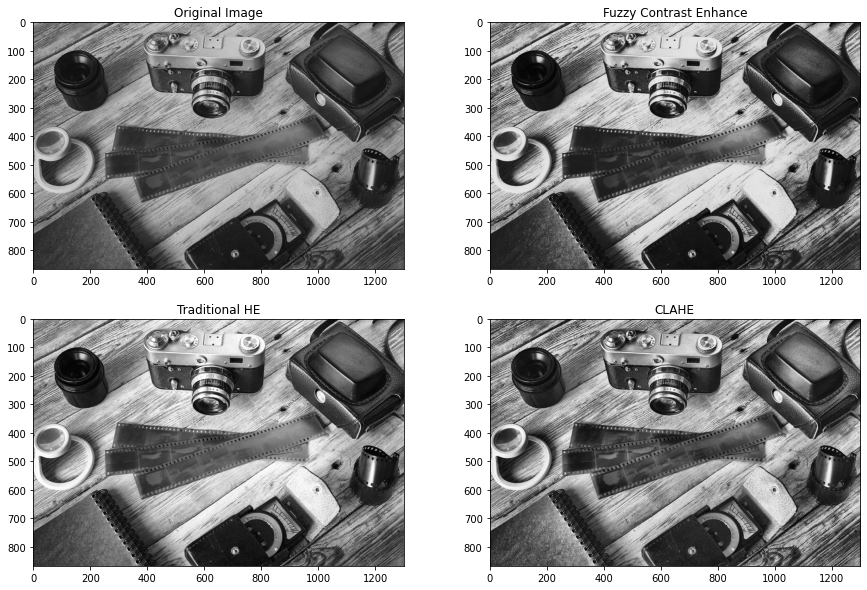

In [16]:
    img = data
    fce = FuzzyContrastEnhance(img)
    he = HE(img)
    clahe = CLAHE(img) 
    #display(Markdown(f'### <p style="text-align: center;">Sample Photo {i+1}</p>'))
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(data)
    plt.title('Original Image')
    
    plt.subplot(2, 2, 2)
    plt.imshow(fce)
    plt.title('Fuzzy Contrast Enhance')
    
    plt.subplot(2, 2, 3)
    plt.imshow(he)
    plt.title('Traditional HE')
    
    plt.subplot(2, 2, 4)
    plt.imshow(clahe)
    plt.title('CLAHE')
    
    plt.show()

**V. Evaluation**
1. **Execution Time**

**Fuzzy Contrast Enchance**

In [19]:
%%time
FuzzyContrastEnhance(data)

CPU times: user 203 ms, sys: 4.12 ms, total: 208 ms
Wall time: 194 ms


array([[[ 90,  90,  90],
        [ 96,  96,  96],
        [105, 105, 105],
        ...,
        [ 14,  14,  14],
        [ 24,  24,  24],
        [ 26,  26,  26]],

       [[ 61,  61,  61],
        [113, 114, 113],
        [109, 109, 109],
        ...,
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 24,  24,  24]],

       [[107, 107, 107],
        [186, 186, 186],
        [179, 179, 179],
        ...,
        [ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23]],

       ...,

       [[ 31,  31,  31],
        [ 31,  31,  31],
        [ 30,  30,  30],
        ...,
        [ 70,  70,  70],
        [ 57,  57,  57],
        [ 41,  41,  41]],

       [[ 30,  30,  30],
        [ 30,  30,  30],
        [ 30,  29,  29],
        ...,
        [ 68,  68,  68],
        [ 54,  54,  54],
        [ 57,  57,  57]],

       [[ 30,  30,  30],
        [ 30,  30,  30],
        [ 30,  29,  29],
        ...,
        [ 57,  57,  57],
        [ 65,  65,  65],
        [ 88,  88,  88]]

**Traditional HE**

In [20]:
%%time
HE(data)

CPU times: user 43.5 ms, sys: 691 µs, total: 44.2 ms
Wall time: 29.4 ms


array([[[115, 114, 114],
        [117, 117, 117],
        [123, 123, 123],
        ...,
        [ 15,  15,  15],
        [ 29,  29,  29],
        [ 32,  32,  32]],

       [[ 96,  96,  96],
        [129, 129, 129],
        [125, 125, 125],
        ...,
        [ 30,  30,  30],
        [ 30,  30,  30],
        [ 29,  29,  29]],

       [[124, 124, 124],
        [172, 172, 172],
        [166, 166, 166],
        ...,
        [ 29,  29,  29],
        [ 27,  27,  27],
        [ 27,  27,  27]],

       ...,

       [[ 48,  48,  48],
        [ 49,  49,  49],
        [ 45,  45,  45],
        ...,
        [104, 104, 104],
        [ 93,  93,  93],
        [ 71,  71,  71]],

       [[ 45,  45,  45],
        [ 45,  45,  45],
        [ 42,  43,  42],
        ...,
        [102, 102, 102],
        [ 90,  90,  90],
        [ 93,  93,  93]],

       [[ 45,  45,  45],
        [ 45,  45,  45],
        [ 42,  43,  42],
        ...,
        [ 93,  93,  93],
        [ 99,  99,  99],
        [113, 114, 113]]

**CLAHE**

In [21]:
%%time
CLAHE(data)

CPU times: user 50.7 ms, sys: 2.67 ms, total: 53.3 ms
Wall time: 32.3 ms


array([[[ 60,  60,  60],
        [ 66,  66,  66],
        [ 75,  75,  75],
        ...,
        [  6,   7,   7],
        [ 17,  17,  17],
        [ 19,  19,  19]],

       [[ 40,  40,  40],
        [ 84,  84,  84],
        [ 78,  78,  78],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 17,  17,  17]],

       [[ 77,  77,  77],
        [164, 164, 164],
        [153, 153, 153],
        ...,
        [ 17,  17,  17],
        [ 16,  16,  16],
        [ 16,  16,  16]],

       ...,

       [[ 47,  48,  47],
        [ 49,  49,  49],
        [ 43,  43,  43],
        ...,
        [130, 130, 130],
        [113, 114, 113],
        [ 82,  82,  82]],

       [[ 43,  43,  43],
        [ 43,  43,  43],
        [ 38,  38,  38],
        ...,
        [128, 128, 128],
        [112, 112, 112],
        [113, 114, 113]],

       [[ 43,  43,  43],
        [ 43,  43,  43],
        [ 38,  38,  38],
        ...,
        [113, 114, 113],
        [123, 123, 123],
        [150, 150, 150]]

**2. Peak Signal-to-Noise Ratio (PSNR)**

In [22]:
def MSE(img1, img2):
    return np.mean(np.square(img1 - img2))

def PSNR(Max, MSE):
    return 10*math.log10(Max**2/MSE)

In [24]:
display(Markdown(f'FCE: {PSNR(255*255, np.mean([MSE(data, FuzzyContrastEnhance(data))]))}'))
display(Markdown(f'HE: {PSNR(255*255, np.mean([MSE(data, HE(data))]))}'))
display(Markdown(f'CLAHE: {PSNR(255*255, np.mean([MSE(data, CLAHE(data))]))}'))

FCE: 76.13299658954477

HE: 76.6561539344856

CLAHE: 76.87849070513882